In [44]:
import pennylane as qml
from pennylane import numpy as qnp
import numpy as np
import math

In [91]:
n = 4
m = 10
shots = 128
l = 1
rule30_patterns = [
    (1, 0, 0),
    (0, 1, 1),
    (0, 1, 0),
    (0, 0, 1),
]

In [92]:
def cccnot(c1, c2, c3, target, ancilla):
    qml.Toffoli(wires=[c1, c2, ancilla])
    qml.Toffoli(wires=[c3, ancilla, target])
    qml.Toffoli(wires=[c1, c2, ancilla])

In [93]:
def apply_rule(n, t, i, rule, ancilla_wire):
    def qubit(timestep, pos):
        return n * timestep + pos

    if i == 0:
        if rule[0]: return
        for j in [1, 2]:
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
        qml.Toffoli(wires=[qubit(t, i + 1), qubit(t, i + 2), qubit(t + 1, i + 1)])
        for j in [1, 2]:
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
    elif i == n - 1:
        if rule[2]: return
        for j in [0, 1]:
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
        qml.Toffoli(wires=[qubit(t, i), qubit(t, i + 1), qubit(t + 1, i + 1)])
        for j in [0, 1]:
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
    else:
        for j in range(3):
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
        cccnot(
            qubit(t, i),
            qubit(t, i + 1),
            qubit(t, i + 2),
            qubit(t + 1, i + 1),
            ancilla_wire
        )
        for j in range(3):
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))

In [94]:
def initialize_state(n, with_entanglement: bool, mixed_init: bool):
    for i in range(n):
        if with_entanglement:
            if mixed_init:
                if i == n // 2:
                    qml.PauliX(i)
                else:
                    qml.Hadamard(i)
            else:
                qml.Hadamard(i)
        else:
            qml.PauliX(i)

In [95]:
def initialize_from_probs(prob_vector: np.ndarray):
    qml.AmplitudeEmbedding(features=prob_vector, wires=range(n), normalize=True)

In [96]:
def run_window(n, l, shots, init_probs=None, with_ent=True, mixed_init=False):
    total_qubits = n * l + 1
    ancilla = total_qubits - 1
    dev = qml.device("default.qubit", wires=total_qubits, shots=shots)

    @qml.qnode(dev)
    def qca_window():
        if init_probs is None:
            initialize_state(n, with_ent, mixed_init)
        else:
            # Use real-amplitude embedding to initialize t=0
            initialize_from_probs(init_probs)

        for t in range(l - 1):
            for i in range(n):
                for pattern in rule30_patterns:
                    apply_rule(n, t, i, pattern, ancilla)
        return qml.probs(wires=[n * (l - 1) + i for i in range(n)])

    return qca_window()

In [97]:
def to_bits(n, bits):
    return np.array([int(i) for i in bin(n)[2:].zfill(bits)])

In [98]:
def probs_to_grid(probs):
    nprobs = probs.size
    n = int(math.log2(nprobs))
    assert (1 << n == nprobs)
    avg = np.zeros((n))
    for i in range(n):
        bits = to_bits(i, n)
        avg += probs[i] * bits
    return avg

In [99]:
def simulate_sliding_qca(n: int, m: int, l: int, shots: int, with_ent=True, mixed_init=False):
    grid = np.zeros((n, m))

    init_probs = None
    for t_start in range(0, m - l + 1):
        print(f"Window start: t = {t_start}")
        probs = run_window(n, l, shots, init_probs, with_ent, mixed_init)

        # Store window outputs: only update new columns
        for i in range(l):
            t_idx = t_start + i
            avgs = probs_to_grid(probs)
            if t_idx < m:
                grid[:, t_idx] = avgs

        # Next window init: last timestep's output probs
        init_probs = probs

    return grid

Window start: t = 0
Window start: t = 1
Window start: t = 2
Window start: t = 3
Window start: t = 4
Window start: t = 5
Window start: t = 6
Window start: t = 7
Window start: t = 8
Window start: t = 9


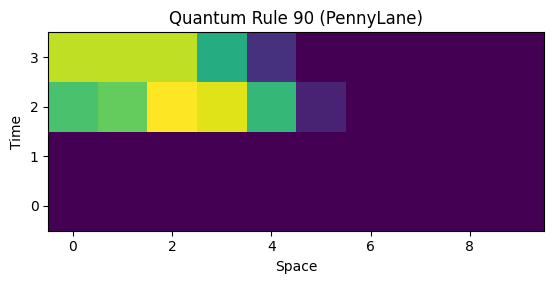

In [100]:
grid = simulate_sliding_qca(n, m, l, shots)

# Normalize to get probabilities

import matplotlib.pyplot as plt
# Visualize
plt.imshow(grid, cmap="viridis", interpolation='nearest')
plt.title("Quantum Rule 90 (PennyLane)")
plt.xlabel("Space")
plt.ylabel("Time")
plt.gca().invert_yaxis()  # match classical automata convention
plt.show()